In [1]:
# import all modules
import shutil
import glob
import csv
import ast
import os
import re

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem

from mendeleev import element

from rdkit import Chem
import seaborn as sns
import pandas as pd
import numpy as np

from astroquery.linelists.cdms import CDMS
from astroquery.jplspec import JPLSpec
import astropy.units as u
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [223]:
## CDMS ##
# phosphine, methanol, formic acid, not used: cyclopropene,'040506 c-C3H4'
CDMS_molecule_list = ['034501 PH3','032504 CH3OH','046506 t-HCOOH']

## JPL ##
# acetonitrile, acetaldehyde, methylformate
JPL_molecule_list = ['41001 CH3CN','44003 CH3CHO','60003 CH3OCHO']

molecule_names_list = [r'Phosphine - PH$_3$', r'Methanol - CH$_3$OH', 
                       r'Formic Acid - HCOOH', r'Acetonitrile - CH$_3$CN',
                       r'Acetaldehyde - CH$_3$CHO', r'Methylformate - CH$_3$OCHO']

all_list = [('034501 PH3',r'Phosphine - PH$_3$','CDMS',0,0, 30, 'P'), ('030501 H2CO', r'Formaldehyde - CH$_2$O', 'CDMS', 0, 1, 20, 'C=O'),
            ('032504 CH3OH',r'Methanol - CH$_3$OH','CDMS',1,0, 40, 'OC'),('046506 t-HCOOH',r'Formic Acid - HCOOH','CDMS',1,1,15,'O=CO'),
            ('040506 c-C3H4', r'Cyclopropene - C$_3$H$_4$', 'CDMS',2,0,15,'C1=CC1'), ('065514 HCCCH2CN',r'Propargyl cyanide - HCCCH$_2$CN','CDMS', 2,1,15,'C#CCC#N')]
           
           #('41001 CH3CN',r'Acetonitrile - CH$_3$CN','JPL',1,1,'N#CC'),
           #('44003 CH3CHO',r'Acetaldehyde - CH$_3$CHO','JPL',2,0,'O=CC'),('60003 CH3OCHO',r'Methylformate - CH$_3$OCHO','JPL',2,1,'O=COC')]

In [381]:
observed_data = CDMS.query_lines(min_frequency=0*u.MHz,
                         max_frequency=6e6*u.MHz,
                         min_strength=-10,
                         temperature_for_intensity=9.375,
                         molecule='032504 CH3OH') 
observed_data

FREQ,ERR,LGINT,DR,ELO,GUP,TAG,QNFMT,Ju,Ku,vu,Jl,Kl,vl,F,name
MHz,MHz,MHz nm2,,1 / cm,,,,,,,,,,,
float64,float64,float64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str8,str13
834.28,0.0,-5.8172,3,11.7049,12,32504,1404,1,1,0,0,--,--,1 1 1 0,"CH3OH, vt=0-2"
2502.768,0.001,-5.3342,3,14.9043,20,32504,1404,2,1,1,0,--,--,2 1 2 0,"CH3OH, vt=0-2"
5005.302,0.002,-5.2109,3,19.7031,28,32504,1404,3,1,2,0,--,--,3 1 3 0,"CH3OH, vt=0-2"
6668.564,0.01,-4.8742,3,33.8759,44,32504,1404,5,1,5,0,--,--,6 0 6 0,"CH3OH, vt=0-2"
8341.59,0.003,-5.3118,3,26.1012,36,32504,1404,4,1,3,0,--,--,4 1 4 0,"CH3OH, vt=0-2"
9400.854,0.01,-9.1229,3,49.0352,52,32504,1404,6,2,5,1,--,--,7 1 7 2,"CH3OH, vt=0-2"
9936.142,0.01,-7.608,3,76.1021,76,32504,1404,9,1,9,2,--,--,8 2 6 2,"CH3OH, vt=0-2"
9978.721,0.014,-6.5813,3,50.4135,36,32504,1404,4,3,2,0,--,--,5 2 3 0,"CH3OH, vt=0-2"


In [301]:
comp_data = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/PGOPHER Simulations/Full/H3P.csv',header=1)
comp_data

,Molecule,Upper Manifold,J',Sym',#',Lower Manifold,"J""","Sym""","#""",Position,Intensity,Eupper,Elower,Spol,A,Width,Branch,Label
0,SymmetricTop,Ground,1.0,A+,1.0,Ground,0.0,A+,1.0,8.9,3.124624e-02,8.90,0.00,0.121605,0.000027,0.0,qR0(0),v=0 1 0 A2 - v=0 0 0 A1
1,SymmetricTop,Ground,2.0,E,2.0,Ground,1.0,E,1.0,17.8,1.628239e-02,26.17,8.37,0.182408,0.000194,0.0,qR1(1),v=0 2 1 E - v=0 1 1 E
2,SymmetricTop,Ground,2.0,A+,1.0,Ground,1.0,A+,1.0,17.8,2.001391e-02,26.70,8.90,0.243211,0.000258,0.0,qR0(1),v=0 2 0 A1 - v=0 1 0 A2
3,SymmetricTop,Ground,3.0,E,1.0,Ground,2.0,E,1.0,26.7,1.581341e-03,51.28,24.58,0.202676,0.000519,0.0,qR2(2),v=0 3 2 E - v=0 2 2 E
4,SymmetricTop,Ground,3.0,A+,2.0,Ground,2.0,A+,1.0,26.7,2.055881e-03,53.40,26.70,0.364816,0.000933,0.0,qR0(2),v=0 3 0 A2 - v=0 2 0 A1
5,SymmetricTop,Ground,3.0,E,2.0,Ground,2.0,E,2.0,26.7,1.982305e-03,52.87,26.17,0.324281,0.000830,0.0,qR1(2),v=0 3 1 E - v=0 2 1 E
6,SymmetricTop,Ground,4.0,A+,2.0,Ground,3.0,A+,2.0,35.6,4.610903e-05,89.00,53.40,0.486421,0.002294,0.0,qR0(3),v=0 4 0 A1 - v=0 3 0 A2
7,SymmetricTop,Ground,4.0,E,3.0,Ground,3.0,E,2.0,35.6,4.689022e-05,88.47,52.87,0.456020,0.002151,0.0,qR1(3),v=0 4 1 E - v=0 3 1 E
8,SymmetricTop,Ground,4.0,E,2.0,Ground,3.0,E,1.0,35.6,4.787925e-05,86.88,51.28,0.364816,0.001721,0.0,qR2(3),v=0 4 2 E - v=0 3 2 E
9,SymmetricTop,Ground,4.0,A+,1.0,Ground,3.0,A+,1.0,35.6,4.194587e-05,84.23,48.63,0.212809,0.001004,0.0,qR3A2(3),v=0 4 3 A1 - v=0 3 3 A2


In [ ]:
data_ground = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/B971_def2TZVPD_DataFile1_GroundState.csv')
data_all = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/B971_def2TZVPD_DataFile1.csv')
data = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/6_Atoms/biosig_CHNOPS.csv')
data_bio = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/6_Atoms/biosig_data.csv')

# Functions

In [33]:
def have_hyperfine(file):
    with open(file, 'r') as inp:
        for line in inp:
            line = line.strip()
            if line.startswith('Atoms with significant hyperfine tensors:'):
                if len(line.split()) == 5:
                    hyperfine = 'No'
                elif len(line.split()) > 5:
                    hyperfine = 'Yes'
    return hyperfine
    

In [26]:
def grab_constant(inp,quartic_constants):
    rot_info = next(inp).split()
    quartic_constants.append(float(rot_info[3])/29979.2458)
    return

def get_quartic_rotational_constants(file): 
    quartic_constants = []
    with open(file, 'r') as inp:
        for line in inp:
            line = line.strip()
            if line.startswith('(Asymmetrically reduced)          (Symmetrically reduced)'):
                for n in range(0,5,1):
                    grab_constant(inp,quartic_constants)
    return quartic_constants

In [47]:
## get lines from CDMS ## 
def CDMS_get_frequencues_intensities(molecule):
    ''' Grabs frequency and intensity data from CDMS for a molecule.
    
    Parameters 
    ----------
    molecule: string
              CDMS code for molecule, as given in https://cdms.astro.uni-koeln.de/cgi-bin/cdmssearch
              
    Returns
    -------
    freq: list of floats
                 List of frequencies of transitions in frequency range. Given in cm-1 units.
    
    intens:  list of floats
                 List of intensities of molecule in frequency range. Given in normalized arbitrary units.
    '''
    table = CDMS.query_lines(min_frequency=0*u.MHz,
                         max_frequency=6e6*u.MHz,
                         min_strength=-10,
                         temperature_for_intensity=9.375,
                         molecule=molecule) 
    freq = np.array(table['FREQ'])*0.0000334
    intens = 10**np.array(table['LGINT'])/np.max((10**np.array(table['LGINT'])))
    
    return freq, intens

In [62]:
## get lines from JPL ## 
def JPL_get_frequencues_intensities(molecule):
    ''' Grabs frequency and intensity data from JPL for a molecule.
    
    Parameters 
    ----------
    molecule: string
              JPL code for molecule, as given in https://spec.jpl.nasa.gov/ftp/pub/catalog/catform.html
              
    Returns
    -------
    freq: list of floats
                 List of frequencies of transitions in frequency range. Given in MHz units.
    
    intens:  list of floats
                 List of intensities of molecule in frequency range. Given in Log form and MHz nm2 units.
    '''
    table =  JPLSpec.query_lines(min_frequency=0*u.MHz,
                         max_frequency=9e7*u.MHz,
                         min_strength=-10,
                         molecule=molecule) 
    freq = np.array(table['FREQ'])*0.0000334
    intens = 10**np.array(table['LGINT'])/np.max((10**np.array(table['LGINT'])))
    return freq, intens

In [162]:
def simulated_frequencies_intensities(formula):
    df = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/PGOPHER Simulations/Full/'+formula+'.csv',header=1)

    freq = np.array(df['Position'])
    intens = np.array(df['Intensity'])/np.nanmax(df[['Intensity']].values)
    return freq, intens

In [190]:
def plot_CDMS_JPL(freq, intens, source, i , j):
    ''' Short sentence here.
    
    Parameters
    ----------
    
    Returns 
    -------
    
    '''
    #freq_axis, intens_axis = givewidth(freq, intens) # normalize intensities again
    #ax[i,j].plot(freq, -np.array(intens),
    #        color='grey', label = source)
    markers,stems,base = ax[i,j].stem(freq,-intens,markerfmt=' ', basefmt='k:', linefmt='grey')
    plt.setp(stems, 'linewidth', 1)
    return

In [191]:
def plot_simulation(freq, intens, i , j):
    markers,stems,base = ax[i,j].stem(freq,intens,markerfmt=' ', basefmt='k:', linefmt='steelblue')
    plt.setp(stems, 'linewidth', 1)
    return
    

In [238]:
def wavenumbers2MHz(x):
    return (x * 29979.2458)/1000

def MHztowavenumbers(x):
    return x * 0.0000334

In [379]:
def compute_RMSE_positions(formula,mol_id):
    comp_data = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/PGOPHER Simulations/Full/'+formula+'.csv',header=1)
    observed_data = CDMS.query_lines(min_frequency=0*u.MHz,
                         max_frequency=6e6*u.MHz,
                         min_strength=-10,
                         temperature_for_intensity=9.375,
                         molecule=mol_id) 
    
    comp_label_list = np.array(comp_data["J'"].values)
    observed_label_list = np.array(observed_data['Ju'])

    print(comp_label_list)
    print(observed_label_list)

    comp_freq_list = np.array(comp_data['Position'].values)
    observed_freq_list = np.array(observed_data['FREQ'])*0.0000334

    n_4=0
    n_6=0
    n_10=0
    n_20=0
    n_30=0
    sum_diff_sq_4 = 0
    sum_diff_sq_6 = 0
    sum_diff_sq_10 = 0
    sum_diff_sq_20 = 0
    sum_diff_sq_30 = 0
    J_list = []

    # for label in observed_label_list:
    #     J_list.append(label)
    #     try:
    #         index_comp = comp_label_list.index(label)
    #         index_obs = observed_label_list.index(label)
    #         if label < 4:
                
    #             sum_diff_sq_4 += (comp_freq_list[index_comp]-observed_freq_list[index_obs])**2
    #             n_4+=1
    #         elif label < 6:
    #             sum_diff_sq_6 += (comp_freq_list[index_comp]-observed_freq_list[index_obs])**2
    #             n_6+=1
    #         elif label < 10: 
    #             sum_diff_sq_10 += (comp_freq_list[index_comp]-observed_freq_list[index_obs])**2
    #             n_10+=1
    #         elif label < 20: 
    #             sum_diff_sq_20 += (comp_freq_list[index_comp]-observed_freq_list[index_obs])**2
    #             n_20+=1
    #         elif label < 30: 
    #             sum_diff_sq_30 += (comp_freq_list[index_comp]-observed_freq_list[index_obs])**2
    #             n_30+=1
            
    #     except:
    #         #index_obs = observed_label_list.index(label)
    #         #sum_diff_sq += (observed_freq_list[index_obs])**2
    #         print(label)
    #     print(np.sqrt(sum_diff_sq_4/n_4))
    #     print(np.sqrt(sum_diff_sq_6/n_6))
    #     print(np.sqrt(sum_diff_sq_10/n_10))
    #     print(np.sqrt(sum_diff_sq_20/n_20))
    #     print(np.sqrt(sum_diff_sq_30/n_30))


        
        
    return

In [380]:
compute_RMSE_positions('CH2O2','046506 t-HCOOH')

[ 5.  6.  2.  7.  3.  8.  9.  4.  5.  1.  6.  3.  7.  2.  8.  8.  9.  3.
 10.  4. 11.  6.  1.  1.  5. 12.  4.  9.  6.  9.  8.  2.  2.  7.  2.  5.
 10.  5.  7.  8.  9.  3. 10.  3.  1.  3.  3.  6.  2.  3. 10.  3.  9.  4.
  4.  6.  8.  5.  5.  6.  4. 10.  1.  4.  4.  4.  4.  4. 10.  7.  4.  7.
 11.  9.  4.  8.  3.  7. 11.  5.  2.  9.  5.  9.  5.  5.  5.  5.  5.  5.
  6.  5.  3. 10.  8. 12.  2. 12.  3.  6.  8.  8.  6. 11.  5.  6.  6.  6.
  6.  6.  6.  6.  6.  2.  6. 13.  4.  7. 12.  7.  7.  4.  7.  9.  7.  7.
  7.  7.  7.  7.  7.  7. 13.  7. 13. 13.  5. 12. 11. 10.  6.  8.  9.  6.
  3.  8.  8.  8.  8.  8.  8.  8.  8.  8.  7.  8. 10.  6.  6.  8.  5.  4.
  9.  3.  5.  2.  5.  9.  2.  9.  2.  9.  9.  9.  9.  7.  9.  9.  3.  9.
  4. 11.  9.  5. 10.  6.  8.  4. 10.  4.  7. 10. 10. 10. 10. 10. 10. 10.
 10.  8. 10. 12.  9.  9. 11.  9.  9. 11.  3.  3.  2. 10.  2. 11. 11. 11.
 11. 11. 11. 11. 11. 10. 11. 11. 12. 13. 12.  8.  8. 12.  3.  2.  3.  4.
  5.  6. 12.  9.  7.  3. 11. 12. 12. 12. 12.  8.  9

# Get Constants of 6 Molecules

In [239]:
df = pd.DataFrame(columns = ['Formula','SMILES','# Atoms','Conf#', 'mu_a [D]', 'mu_b [D]', 
                             'mu_c [D]', 'A [cm-1]', 'B [cm-1]', 'C [cm-1]', 'Delta_N [cm-1]',
                              'Delta_K [cm-1]', 'Delta_NK [cm-1]', 'delta_N [cm-1]', 'delta_K [cm-1]',
                               'hyperfine'])


In [240]:
# make 6 molecule dataframe 
for mol in all_list:
    SMILES = mol[-1]
    formula = data_ground[data_ground['SMILES'] == SMILES]['Formula'].values[0]
    num_atoms = data_ground[data_ground['SMILES'] == SMILES]['# Atoms'].values[0]
    conf = data_ground[data_ground['SMILES'] == SMILES]['Conf#'].values[0]
    mu_a, mu_b, mu_c = data_ground[data_ground['SMILES'] == SMILES]['mu_a [D]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['mu_b [D]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['mu_c [D]'].values[0]
    A ,B, C = data_ground[data_ground['SMILES'] == SMILES]['A [cm-1]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['B [cm-1]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['C [cm-1]'].values[0]
    
    if num_atoms < 6:
        folder_num = 6
    elif (num_atoms > 6) & (num_atoms <= 8):
        folder_num = 8

    file = '/Users/z5380625/Documents/Research/4_BigData/'+str(folder_num)+'_Atoms/4_VibrationalCalcs/OutputFiles/'+formula+'_'+conf+'_harmonic_conformers.log'
    
    hyperfine = have_hyperfine(file)
    Delta_N, Delta_K, Delta_NK, delta_N, delta_K = get_quartic_rotational_constants(file)

    row_info = list([SMILES,formula,num_atoms,conf,mu_a,mu_b,mu_c,A ,B, C, Delta_N, Delta_K, Delta_NK, delta_N, delta_K, hyperfine])
    df.loc[len(df)] = row_info

In [241]:
df.to_csv('/Users/z5380625/Documents/Research/4_BigData/simulation_data_six.csv',index=False,sep=',')

# Plot

H3P
CH2O
CH4O
CH2O2
C3H4_1
C4H3N_5


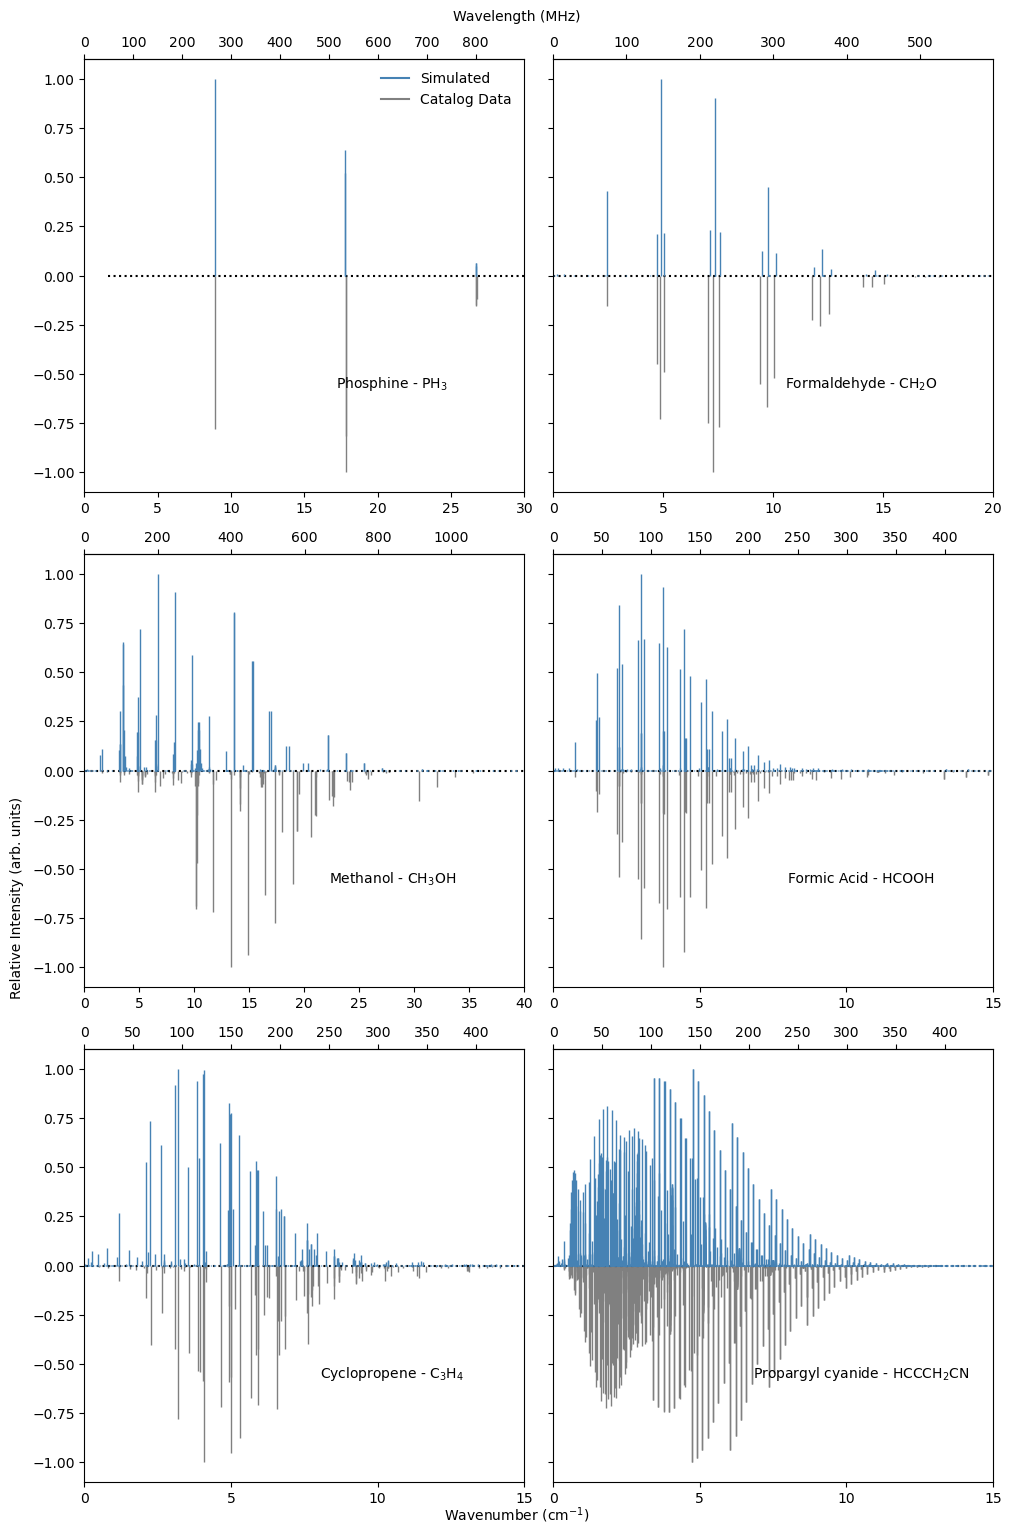

In [347]:
i_index = [0,0,1,1,2,2]
j_index = [0,1,0,1,0,1]

fig, ax = plt.subplots(3,2,figsize=(10,15)) 
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.1)
fig.text(0.00,0.35,"Relative Intensity (arb. units)", rotation = 'vertical', horizontalalignment = 'center')
fig.text(0.5,0.0,"Wavenumber (cm$^{-1}$)", rotation = 'horizontal', horizontalalignment = 'center')
fig.text(0.5,1.0,"Wavelength (MHz)", rotation = 'horizontal', horizontalalignment = 'center')
source_line = Line2D([0], [0], label='Catalog Data', color='grey')
scaled_harm = Line2D([0], [0], label='Simulated', color='steelblue')
handles_mc = [scaled_harm,source_line]
ax[0,0].legend(handles= handles_mc, ncol = 1, frameon=False, loc = 'upper right')


for mol in all_list:
    mol_id = mol[0]
    mol_formula = data_ground[data_ground['SMILES']==mol[-1]]['Formula'].values[0]
    print(mol_formula)
    mol_label = mol[1]
    source = mol[2]
    i, j = mol[3], mol[4]
    upper = mol[5]

    #compute_RMSE_positions(mol_formula,mol_id)
    
    if source == 'CDMS':
        freq_observ, intens_observ = CDMS_get_frequencues_intensities(mol_id)
        freq_sim, intens_sim = simulated_frequencies_intensities(mol_formula)
    elif source == 'JPL':
        freq, intens = JPL_get_frequencues_intensities(mol_id)
    
    plot_CDMS_JPL(freq_observ, intens_observ, source, i , j)
    plot_simulation(freq_sim,intens_sim,i, j)

    # ax2 = ax[i,j].twiny() 
    # ax2.set_xticks(ax[0,0].get_xticks()) 
    # ax2.set_xbound(ax[0,0].get_xbound()) 
    # ax2.set_xticklabels(tick_function(ax[0,0].get_xticks())) 
    # ax2.set_xlabel(None) 



    ax[i, j].set_xlim(0, upper)
    ax[i, j].set_xticks(np.arange(0,upper+5,5))
    ax[i, j].set_xticklabels(np.arange(0,upper+5,5))

    ax[i,j].secondary_xaxis('top',functions=(wavenumbers2MHz, MHztowavenumbers))

    ax[i,j].text(0.7,0.25,mol_label,horizontalalignment='center',
    verticalalignment='center',transform = ax[i,j].transAxes)

ax[0,1].set_yticklabels([]) 
ax[1,1].set_yticklabels([]) 
ax[2,1].set_yticklabels([]) 

plt.tight_layout()
 
plt.show()